<center>
<b><font size=6>Industry 4.0 의 중심, BigData</font></b>
</center>

<div align='right'><font size=2 color='gray'>Data Processing Based Python @ <font color='blue'><a href='https://www.facebook.com/jskim.kr'>FB / jskim.kr</a></font>, 김진수</font></div>
<hr>

## <font color='brown'> 대선 결과 분석 </font>
>  ### 중앙선거관리위원회 선거통계시스템
- 사이트 : http://info.nec.go.kr/
- 19대 대통령선거 결과데이터 크롤링 및 분석
- 결과 확인할 수 있는 페이지 : [바로가기](http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09)

<hr>

### <font color='#00CCCC'> STEP1 : 데이터 획득 준비 작업 </font>

In [1]:
from images import bigpycraft_bda as bpc
from IPython.display import Image 

In [2]:
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    print("It's unknown system. Hangul fonts are not supported!")
    
plt.rcParams["figure.figsize"] = [12,6]

%matplotlib inline

In [3]:
! pip install selenium

In [4]:
from selenium import webdriver
import time
import re

In [5]:
driver = webdriver.Chrome('./driver/chromedriver.exe')

In [6]:
# 선거결과확인페이지로 바로 이동
page_url = 'http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09'
driver.get(page_url)

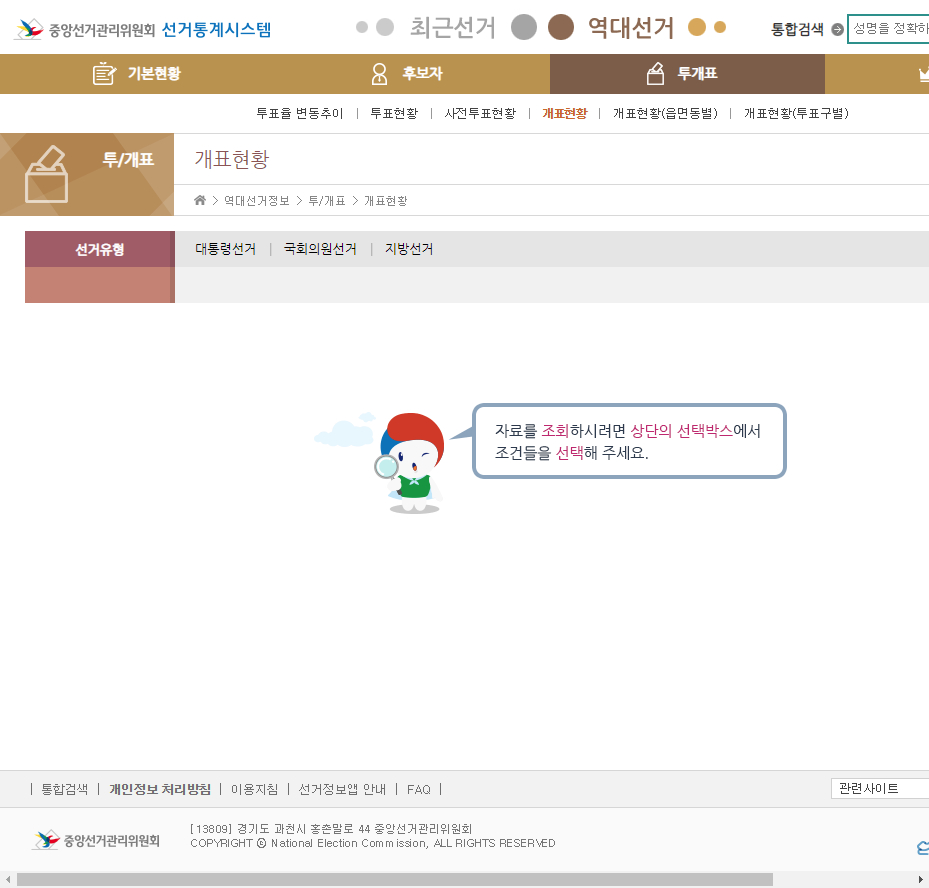

In [7]:
capture_img = './images/electionInfo.png'
driver.save_screenshot(capture_img)
Image(capture_img)

#### 대통령선거 클릭 : 제19대 > 대통령선거 > 전체 를 선택후 검색 클릭

In [8]:
# 대통령선거 클릭 : id=electionType1
driver.find_element_by_id("electionType1").click()

In [9]:
# 제19대 선택
driver.find_element_by_id("electionName").send_keys("제19대")

In [10]:
# 선거 : 대통령선거
driver.find_element_by_id("electionCode").send_keys("대통령선거")

In [11]:
# 시도 : ▷ 전 체
driver.find_element_by_name("cityCode").send_keys("▷ 전 체")

In [12]:
# 검색버튼 클릭
driver.find_element_by_css_selector('#searchBtn').click()

#### 결과보기 확인

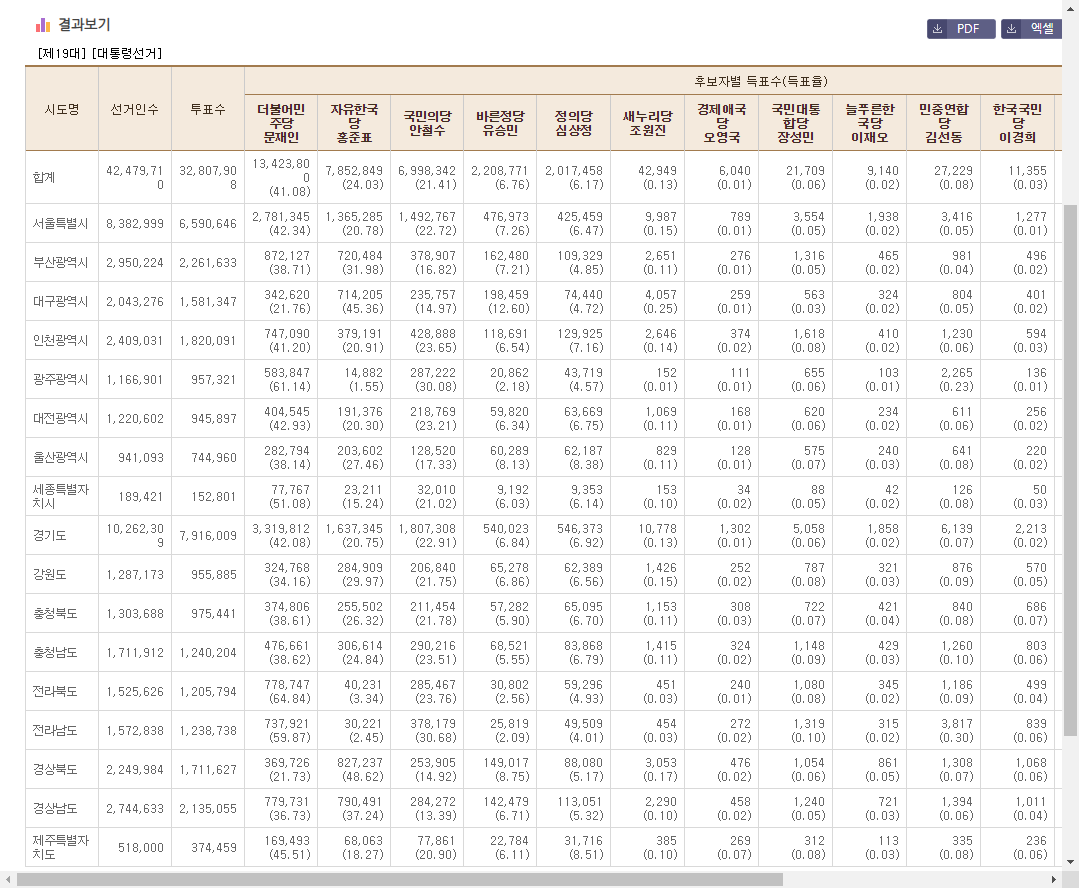

In [14]:
capture_img = './images/electionInfo_report.png'
driver.save_screenshot(capture_img)
Image(capture_img)

In [15]:
# 시도항목 리스트 정보: select box의 id 기반으로 option 리스트 가져온다.
sido_list_raw = driver.find_element_by_xpath("""//*[@id="cityCode"]""")
sido_list = sido_list_raw.find_elements_by_tag_name("option")
sido_names_values = [ option.text for option in sido_list ]
sido_names_values

['▽ 선 택',
 '▷ 전 체',
 '서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [16]:
sido_names_values = sido_names_values[2:]
sido_names_values

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

<hr>

### <font color='#00CCCC'> STEP2 : 대선 개표 결과 데이터 수집 </font>
- 결과테이블에서 득표수에 아래의 괄호()는 득표율이다.
- 괄호 (를 기준으로 왼쪽 숫자만 얻어서, 콤마(,)를 제거하고, float형으로 변경하는 함수를 get_num으로 준비

In [18]:
from bs4 import BeautifulSoup
import re

def get_num_2(tmp):
    return float(re.split('\(', str(tmp))[0].replace(',',''))

def get_num(tmp):
    ret_val = str(tmp)
    ret_val = re.split('\(', ret_val)[0]
    ret_val = ret_val.replace(',','')
    ret_val = float(ret_val)
    return ret_val

#### move_sido
>  
* 화면이 바로 뜨지 않을 경우, wait.until 함수를 사용
* 이 함수는 **검색**버튼이 클릭가능할 때 까지 기다리는 기능을 한다.
* 아래 **move_sido** 함수는 광역시도 이름을 리스트에 전송하고 검색 버튼을 누르는 역할을 한다.

In [19]:
from selenium.webdriver.common.by  import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support    import expected_conditions as EC

wait = WebDriverWait(driver, 10)

def move_sido(name):
    element = driver.find_element_by_id("cityCode")
    element.send_keys(name)
    make_xpath = """//*[@id="searchBtn"]"""
    wait.until(EC.element_to_be_clickable((By.XPATH,make_xpath)))
    driver.find_element_by_xpath(make_xpath).click() 

#### append_data
>   
* 이 함수는 빈 내용으로 미리 준비한 DataFrame에 append 명령으로 읽은 데이터를 하나씩 추가한다.
* 함수가 실행되면 전체 투표수, 각 후보의 득표수가 추가된다.

In [20]:
def append_data(df, sido_name, data):
    for each in df[0].values[1:]:
        data['광역시도'].append(sido_name)
        data['시군'].append(each[0])
        data['pop' ].append(get_num(each[2]))
        data['moon'].append(get_num(each[3]))
        data['hong'].append(get_num(each[4]))
        data['ahn' ].append(get_num(each[5]))
        
    return data

* 미리 변수를 하나 만들어 둡니다.

In [21]:
election_result_raw = {'광역시도' : [],
                       '시군' : [],
                       'pop'  : [],
                       'moon' : [],
                       'hong' : [],    
                       'ahn'  : [] }


* 웹프로그래밍을 잘모르는 경우, 웹문서의 table로 읽는 것이 부담될 수도 있지만
* 경우에 따라 html 태그 중 table로 되어 있는 부분을 Beautiful Soup으로 읽어서 padnas의 read_html로 읽는 것이 더 편할때도 있다.

In [22]:
# 서울특별시 결과
each_sido = sido_names_values[0]
move_sido(each_sido)

In [23]:
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')
table = soup.find('table')

In [24]:
df = pd.read_html(str(table))
type(df), len(df)

(list, 1)

In [25]:
type(df[0])

pandas.core.frame.DataFrame

In [26]:
result_df = df[0]
result_df.head()

,구시군명,선거인수,투표수,후보자별 득표수(득표율),무효투표수,기권수,Unnamed: 6_level_0,Unnamed: 7_level_0,Unnamed: 8_level_0,Unnamed: 9_level_0,Unnamed: 10_level_0,Unnamed: 11_level_0,Unnamed: 12_level_0,Unnamed: 13_level_0,Unnamed: 14_level_0,Unnamed: 15_level_0,Unnamed: 16_level_0,Unnamed: 17_level_0,Unnamed: 18_level_0
,더불어민주당문재인,자유한국당홍준표,국민의당안철수,바른정당유승민,정의당심상정,새누리당조원진,경제애국당오영국,국민대통합당장성민,늘푸른한국당이재오,민중연합당김선동,한국국민당이경희,홍익당윤홍식,무소속김민찬,계,Unnamed: 14_level_1,Unnamed: 15_level_1,Unnamed: 16_level_1,Unnamed: 17_level_1,Unnamed: 18_level_1
0,합계,8382999,6590646,"2,781,345(42.34)","1,365,285(20.78)","1,492,767(22.72)","476,973(7.26)","425,459(6.47)","9,987(0.15)",789(0.01),"3,554(0.05)","1,938(0.02)","3,416(0.05)","1,277(0.01)","2,177(0.03)","3,950(0.06)",6568917,21729,1792353
1,종로구,133769,102566,"42,512(41.59)","22,325(21.84)","22,313(21.83)","7,412(7.25)","7,113(6.95)",228(0.22),5(0.00),78(0.07),31(0.03),63(0.06),26(0.02),47(0.04),49(0.04),102202,364,31203
2,중구,109836,82852,"34,062(41.23)","17,901(21.67)","19,372(23.45)","5,874(7.11)","4,993(6.04)",158(0.19),12(0.01),53(0.06),21(0.02),55(0.06),18(0.02),25(0.03),51(0.06),82595,257,26984
3,용산구,197962,148157,"58,081(39.33)","35,230(23.85)","32,109(21.74)","11,825(8.00)","9,773(6.61)",299(0.20),17(0.01),68(0.04),23(0.01),72(0.04),32(0.02),51(0.03),80(0.05),147660,497,49805
4,성동구,259009,203175,"86,686(42.80)","40,566(20.03)","45,674(22.55)","15,859(7.83)","12,936(6.38)",304(0.15),16(0.00),94(0.04),46(0.02),108(0.05),41(0.02),58(0.02),124(0.06),202512,663,55834


In [27]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 19 columns):
(구시군명, 더불어민주당문재인)                             26 non-null object
(선거인수, 자유한국당홍준표)                              26 non-null int64
(투표수, 국민의당안철수)                                26 non-null int64
(후보자별 득표수(득표율), 바른정당유승민)                      26 non-null object
(무효투표수, 정의당심상정)                               26 non-null object
(기권수, 새누리당조원진)                                26 non-null object
(Unnamed: 6_level_0, 경제애국당오영국)                26 non-null object
(Unnamed: 7_level_0, 국민대통합당장성민)               26 non-null object
(Unnamed: 8_level_0, 늘푸른한국당이재오)               26 non-null object
(Unnamed: 9_level_0, 민중연합당김선동)                26 non-null object
(Unnamed: 10_level_0, 한국국민당이경희)               26 non-null object
(Unnamed: 11_level_0, 홍익당윤홍식)                 26 non-null object
(Unnamed: 12_level_0, 무소속김민찬)                 26 non-null object
(Unnamed: 13_level_0, 계)                      26 non-n

In [28]:
result_df.values[1:5]

array([['종로구', 133769, 102566, '42,512(41.59)', '22,325(21.84)',
        '22,313(21.83)', '7,412(7.25)', '7,113(6.95)', '228(0.22)',
        '5(0.00)', '78(0.07)', '31(0.03)', '63(0.06)', '26(0.02)',
        '47(0.04)', '49(0.04)', 102202, 364, 31203],
       ['중구', 109836, 82852, '34,062(41.23)', '17,901(21.67)',
        '19,372(23.45)', '5,874(7.11)', '4,993(6.04)', '158(0.19)',
        '12(0.01)', '53(0.06)', '21(0.02)', '55(0.06)', '18(0.02)',
        '25(0.03)', '51(0.06)', 82595, 257, 26984],
       ['용산구', 197962, 148157, '58,081(39.33)', '35,230(23.85)',
        '32,109(21.74)', '11,825(8.00)', '9,773(6.61)', '299(0.20)',
        '17(0.01)', '68(0.04)', '23(0.01)', '72(0.04)', '32(0.02)',
        '51(0.03)', '80(0.05)', 147660, 497, 49805],
       ['성동구', 259009, 203175, '86,686(42.80)', '40,566(20.03)',
        '45,674(22.55)', '15,859(7.83)', '12,936(6.38)', '304(0.15)',
        '16(0.00)', '94(0.04)', '46(0.02)', '108(0.05)', '41(0.02)',
        '58(0.02)', '124(0.06)', 2025

In [29]:
print(" df : {}, \n each_sido : {}, \n election_result_raw : {}".format(
    df, each_sido, election_result_raw
))


 df : [        구시군명     선거인수      투표수     후보자별 득표수(득표율)             무효투표수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수           바른정당유승민            정의당심상정   
0         합계  8382999  6590646  2,781,345(42.34)  1,365,285(20.78)   
1        종로구   133769   102566     42,512(41.59)     22,325(21.84)   
2         중구   109836    82852     34,062(41.23)     17,901(21.67)   
3        용산구   197962   148157     58,081(39.33)     35,230(23.85)   
4        성동구   259009   203175     86,686(42.80)     40,566(20.03)   
5        광진구   305172   240030    105,512(44.10)     46,368(19.38)   
6       동대문구   304972   236092     98,958(42.06)     51,631(21.94)   
7        중랑구   351986   265706    111,450(42.09)     56,545(21.35)   
8        성북구   378024   295866    129,263(43.82)     57,584(19.52)   
9        강북구   281434   210614     89,645(42.70)     42,268(20.13)   
10       도봉구   293679   229233     94,898(41.55)     47,461(20.78)   
11       노원구   464422   374213    158,167(42.41)     67,590(18.12)   
12       은평구 

In [30]:
type(df), each_sido, election_result_raw

(list,
 '서울특별시',
 {'ahn': [], 'hong': [], 'moon': [], 'pop': [], '광역시도': [], '시군': []})

In [31]:
sido_data = append_data(df, each_sido, election_result_raw)

In [32]:
sido_data

{'ahn': [22313.0,
  19372.0,
  32109.0,
  45674.0,
  52824.0,
  53359.0,
  62778.0,
  66518.0,
  51669.0,
  55600.0,
  96325.0,
  72582.0,
  46237.0,
  52545.0,
  71816.0,
  88128.0,
  61734.0,
  36695.0,
  53994.0,
  60305.0,
  79495.0,
  63977.0,
  80201.0,
  99018.0,
  67499.0],
 'hong': [22325.0,
  17901.0,
  35230.0,
  40566.0,
  46368.0,
  51631.0,
  56545.0,
  57584.0,
  42268.0,
  47461.0,
  67590.0,
  60109.0,
  40513.0,
  46547.0,
  60814.0,
  76601.0,
  59194.0,
  31106.0,
  53615.0,
  54431.0,
  59914.0,
  74891.0,
  97639.0,
  98549.0,
  65893.0],
 'moon': [42512.0,
  34062.0,
  58081.0,
  86686.0,
  105512.0,
  98958.0,
  111450.0,
  129263.0,
  89645.0,
  94898.0,
  158167.0,
  140180.0,
  93768.0,
  117336.0,
  133853.0,
  175882.0,
  121077.0,
  67423.0,
  105834.0,
  121722.0,
  159854.0,
  106416.0,
  128927.0,
  177328.0,
  122511.0],
 'pop': [102566.0,
  82852.0,
  148157.0,
  203175.0,
  240030.0,
  236092.0,
  265706.0,
  295866.0,
  210614.0,
  229233.0,
  37421

In [33]:
election_result_raw = {'광역시도' : [],
                       '시군' : [],
                       'pop'  : [],
                       'moon' : [],
                       'hong' : [],    
                       'ahn'  : [] }

In [34]:
for each_sido in sido_names_values:
    move_sido(each_sido)

    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    table = soup.find('table')

    df = pd.read_html(str(table))

    print(" df : {}, \n each_sido : {}, \n election_result_raw : {}".format(
        df, each_sido, election_result_raw
    ))
    append_data(df, each_sido, election_result_raw)

 df : [        구시군명     선거인수      투표수     후보자별 득표수(득표율)             무효투표수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수           바른정당유승민            정의당심상정   
0         합계  8382999  6590646  2,781,345(42.34)  1,365,285(20.78)   
1        종로구   133769   102566     42,512(41.59)     22,325(21.84)   
2         중구   109836    82852     34,062(41.23)     17,901(21.67)   
3        용산구   197962   148157     58,081(39.33)     35,230(23.85)   
4        성동구   259009   203175     86,686(42.80)     40,566(20.03)   
5        광진구   305172   240030    105,512(44.10)     46,368(19.38)   
6       동대문구   304972   236092     98,958(42.06)     51,631(21.94)   
7        중랑구   351986   265706    111,450(42.09)     56,545(21.35)   
8        성북구   378024   295866    129,263(43.82)     57,584(19.52)   
9        강북구   281434   210614     89,645(42.70)     42,268(20.13)   
10       도봉구   293679   229233     94,898(41.55)     47,461(20.78)   
11       노원구   464422   374213    158,167(42.41)     67,590(18.12)   
12       은평구 

 df : [        구시군명     선거인수      투표수   후보자별 득표수(득표율)           무효투표수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수         바른정당유승민          정의당심상정   
0         합계  2950224  2261633  872,127(38.71)  720,484(31.98)   
1         중구    40448    28604    9,918(34.78)   10,684(37.47)   
2         서구    98536    71446   24,522(34.46)   26,360(37.04)   
3         동구    79720    58304   19,606(33.75)   22,188(38.20)   
4        영도구   109885    78013   30,094(38.75)   25,345(32.63)   
5       부산진구   323551   246124   95,042(38.76)   79,545(32.44)   
6        동래구   229464   181098   67,947(37.65)   59,616(33.03)   
7         남구   233838   181922   68,566(37.83)   59,137(32.63)   
8         북구   258693   203689   83,611(41.22)   61,175(30.16)   
9       해운대구   344624   266870  102,106(38.39)   80,904(30.42)   
10       기장군   124123    94393   39,412(41.90)   26,556(28.23)   
11       사하구   280843   211876   82,452(39.09)   65,252(30.93)   
12       금정구   209881   164127   60,169(36.82)   54,418(33.30)   
13 

 df : [       구시군명     선거인수      투표수   후보자별 득표수(득표율)           무효투표수             기권수  \
  더불어민주당문재인 자유한국당홍준표  국민의당안철수         바른정당유승민          정의당심상정         새누리당조원진   
0        합계  2043276  1581347  342,620(21.76)  714,205(45.36)  235,757(14.97)   
1        중구    68857    52180   11,477(22.09)   24,698(47.54)    7,170(13.80)   
2        동구   294274   226510   47,350(20.99)  100,166(44.41)   31,351(13.90)   
3        서구   173359   127659   22,004(17.32)   68,782(54.15)   17,808(14.02)   
4        남구   136206   100059   19,862(19.94)   50,304(50.51)   13,978(14.03)   
5        북구   355739   276725   62,526(22.69)  121,368(44.05)   42,369(15.37)   
6       수성구   356388   285528   64,922(22.82)  123,074(43.26)   43,698(15.36)   
7       달서구   479081   374766   82,726(22.17)  165,781(44.43)   57,956(15.53)   
8       달성군   179372   137920   31,753(23.13)   60,032(43.73)   21,427(15.60)   

  Unnamed: 6_level_0 Unnamed: 7_level_0 Unnamed: 8_level_0 Unnamed: 9_level_0  \
            경제애국당오영국

 df : [       구시군명     선거인수     투표수   후보자별 득표수(득표율)         무효투표수             기권수  \
  더불어민주당문재인 자유한국당홍준표 국민의당안철수         바른정당유승민        정의당심상정         새누리당조원진   
0        합계  1166901  957321  583,847(61.14)  14,882(1.55)  287,222(30.08)   
1        동구    83378   66287   37,053(56.05)   1,308(1.97)   23,438(35.45)   
2        서구   247595  204787  124,183(60.76)   3,182(1.55)   62,218(30.44)   
3        남구   177247  146037   85,642(58.82)   2,521(1.73)   47,663(32.73)   
4        북구   356097  292001  177,850(61.06)   4,241(1.45)   88,501(30.38)   
5       광산구   302584  248209  159,119(64.27)   3,630(1.46)   65,402(26.42)   

  Unnamed: 6_level_0 Unnamed: 7_level_0 Unnamed: 8_level_0 Unnamed: 9_level_0  \
            경제애국당오영국          국민대통합당장성민          늘푸른한국당이재오           민중연합당김선동   
0       20,862(2.18)       43,719(4.57)          152(0.01)          111(0.01)   
1        1,372(2.07)        2,665(4.03)           13(0.01)            5(0.00)   
2        4,627(2.26)        9,247(4.52)     

 df : [       구시군명     선거인수     투표수   후보자별 득표수(득표율)           무효투표수             기권수  \
  더불어민주당문재인 자유한국당홍준표 국민의당안철수         바른정당유승민          정의당심상정         새누리당조원진   
0        합계   941093  744960  282,794(38.14)  203,602(27.46)  128,520(17.33)   
1        중구   198415  157051   56,657(36.25)   47,625(30.47)   26,458(16.93)   
2        남구   276867  219569   80,662(36.89)   63,331(28.96)   39,040(17.85)   
3        동구   138379  109054   44,931(41.42)   23,701(21.85)   19,290(17.78)   
4        북구   151453  122933   52,058(42.53)   26,596(21.73)   20,115(16.43)   
5       울주군   175979  136353   48,486(35.75)   42,349(31.22)   23,617(17.41)   

  Unnamed: 6_level_0 Unnamed: 7_level_0 Unnamed: 8_level_0 Unnamed: 9_level_0  \
            경제애국당오영국          국민대통합당장성민          늘푸른한국당이재오           민중연합당김선동   
0       60,289(8.13)       62,187(8.38)          829(0.11)          128(0.01)   
1       12,399(7.93)       12,307(7.87)          183(0.11)           21(0.01)   
2       18,536(8.47)       1

 df : [        구시군명      선거인수      투표수     후보자별 득표수(득표율)             무효투표수  \
   더불어민주당문재인  자유한국당홍준표  국민의당안철수           바른정당유승민            정의당심상정   
0         합계  10262309  7916009  3,319,812(42.08)  1,637,345(20.75)   
1     수원시장안구    239609   190917     81,392(42.79)     37,143(19.52)   
2     수원시권선구    290343   222078     95,263(43.05)     42,801(19.34)   
3     수원시팔달구    167122   123458     49,814(40.50)     27,782(22.59)   
4     수원시영통구    264002   220307    105,181(47.88)     33,354(15.18)   
5     성남시수정구    201105   149414     63,867(42.90)     28,395(19.07)   
6     성남시중원구    198663   146801     62,729(42.89)     27,896(19.07)   
7     성남시분당구    403060   338076    139,853(41.47)     71,332(21.15)   
8       의정부시    360255   270404    110,580(41.03)     57,027(21.16)   
9     안양시만안구    215032   167995     70,454(42.08)     35,189(21.02)   
10    안양시동안구    277376   230674    101,278(44.03)     43,072(18.72)   
11       부천시    705885   543777    239,697(44.23)    100,544(18.55)   

 df : [        구시군명     선거인수     투표수   후보자별 득표수(득표율)           무효투표수             기권수  \
   더불어민주당문재인 자유한국당홍준표 국민의당안철수         바른정당유승민          정의당심상정         새누리당조원진   
0         합계  1287173  955885  324,768(34.16)  284,909(29.97)  206,840(21.75)   
1        춘천시   229286  175879   66,874(38.18)   43,494(24.83)   38,684(22.09)   
2        원주시   273858  204233   77,495(38.10)   50,750(24.95)   45,776(22.50)   
3        강릉시   178461  132395   41,565(31.55)   44,421(33.72)   26,895(20.41)   
4        동해시    76059   55542   17,184(31.09)   19,009(34.39)   11,345(20.52)   
5        삼척시    59080   44097   13,496(30.81)   15,971(36.46)    8,185(18.68)   
6        태백시    39001   28101    9,557(34.19)   10,046(35.94)    4,971(17.78)   
7        정선군    33408   23859    8,270(34.88)    8,323(35.10)    4,489(18.93)   
8        속초시    67471   46985   15,045(32.16)   13,883(29.67)   11,031(23.58)   
9        고성군    25637   18692    5,664(30.58)    6,511(35.15)    3,964(21.40)   
10       양양군    23853

 df : [        구시군명     선거인수     투표수   후보자별 득표수(득표율)           무효투표수             기권수  \
   더불어민주당문재인 자유한국당홍준표 국민의당안철수         바른정당유승민          정의당심상정         새누리당조원진   
0         합계  1303688  975441  374,806(38.61)  255,502(26.32)  211,454(21.78)   
1     청주시상당구   140080  106316   42,308(39.97)   27,108(25.61)   21,983(20.76)   
2     청주시서원구   174200  134980   56,521(42.03)   30,471(22.66)   28,912(21.50)   
3     청주시흥덕구   202801  153064   66,281(43.49)   31,023(20.35)   32,756(21.49)   
4     청주시청원구   150781  115327   50,487(43.94)   24,026(20.91)   24,203(21.06)   
5        충주시   172800  127426   43,551(34.35)   38,532(30.39)   28,588(22.54)   
6        제천시   113835   84700   28,517(33.86)   26,977(32.03)   17,768(21.09)   
7        단양군    26699   19905    5,708(28.85)    7,901(39.94)    4,026(20.35)   
8        영동군    43884   32554   10,432(32.25)   10,958(33.87)    7,017(21.69)   
9        보은군    30016   22341    7,268(32.76)    7,587(34.20)    4,910(22.13)   
10       옥천군    44730

 df : [        구시군명     선거인수      투표수   후보자별 득표수(득표율)           무효투표수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수         바른정당유승민          정의당심상정   
0         합계  1711912  1240204  476,661(38.62)  306,614(24.84)   
1     천안시서북구   285471   212329   94,202(44.53)   37,293(17.62)   
2     천안시동남구   207268   151132   59,695(39.67)   34,869(23.17)   
3        공주시    93453    67018   25,036(37.58)   18,449(27.69)   
4        보령시    87274    62825   20,674(33.13)   19,453(31.18)   
5        아산시   236407   173795   73,461(42.45)   36,741(21.23)   
6        서산시   137217    98859   37,376(37.99)   24,572(24.97)   
7        태안군    55379    38740   12,881(33.48)   12,666(32.92)   
8        금산군    46637    32968   11,182(34.17)    9,416(28.78)   
9        논산시   103557    72434   28,265(39.23)   16,948(23.52)   
10       계룡시    32653    26530    9,566(36.20)    6,261(23.69)   
11       당진시   134586    95417   37,191(39.15)   23,597(24.84)   
12       부여군    61041    43288   13,492(31.37)   13,761(32.00)   
13 

 df : [        구시군명     선거인수      투표수   후보자별 득표수(득표율)         무효투표수             기권수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수         바른정당유승민        정의당심상정         새누리당조원진   
0         합계  1525626  1205794  778,747(64.84)  40,231(3.34)  285,467(23.76)   
1     전주시완산구   289452   236383  157,637(66.89)   7,003(2.97)   50,506(21.43)   
2     전주시덕진구   230552   187921  125,375(66.89)   5,183(2.76)   40,188(21.44)   
3        군산시   223599   172330  109,379(63.65)   6,360(3.70)   42,387(24.66)   
4        익산시   246727   192208  123,422(64.45)   6,470(3.37)   45,737(23.88)   
5        정읍시    96162    73678   45,894(62.61)   2,175(2.96)   20,111(27.43)   
6        남원시    70169    55371   35,539(64.51)   1,939(3.52)   13,854(25.15)   
7        김제시    75356    57886   35,870(62.32)   2,052(3.56)   15,880(27.59)   
8        완주군    78249    62470   41,057(65.97)   2,107(3.38)   13,897(22.33)   
9        진안군    22704    18107   11,918(66.17)     819(4.54)    3,904(21.67)   
10       무주군    21591    17019   

 df : [        구시군명     선거인수      투표수   후보자별 득표수(득표율)         무효투표수             기권수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수         바른정당유승민        정의당심상정         새누리당조원진   
0         합계  1572838  1238738  737,921(59.87)  30,221(2.45)  378,179(30.68)   
1        목포시   187620   145476   77,896(53.73)   2,584(1.78)   53,303(36.77)   
2        여수시   235605   185487  117,586(63.63)   4,281(2.31)   50,228(27.18)   
3        순천시   223756   181451  122,595(67.81)   4,525(2.50)   40,429(22.36)   
4        나주시    89312    71599   43,967(61.76)   1,448(2.03)   21,011(29.51)   
5        광양시   120767    96384   63,544(66.15)   4,100(4.26)   20,080(20.90)   
6        담양군    41434    33020   19,961(60.80)     698(2.12)   10,017(30.51)   
7        장성군    39083    30670   17,378(56.93)     851(2.78)   10,167(33.31)   
8        곡성군    26671    21247   12,152(57.73)     624(2.96)    6,850(32.54)   
9        구례군    23487    18924   11,873(63.11)     628(3.33)    5,188(27.57)   
10       고흥군    60101    47036   

 df : [        구시군명     선거인수      투표수   후보자별 득표수(득표율)           무효투표수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수         바른정당유승민          정의당심상정   
0         합계  2249984  1711627  369,726(21.73)  827,237(48.62)   
1      포항시북구   221925   171444   38,629(22.63)   77,138(45.19)   
2      포항시남구   200424   150740   34,808(23.21)   66,319(44.23)   
3        울릉군     8968     6810    1,443(21.33)    3,520(52.03)   
4        경주시   218154   167296   38,092(22.89)   80,090(48.14)   
5        김천시   119825    92184   22,255(24.30)   43,998(48.04)   
6        안동시   139937   107357   23,121(21.68)   52,978(49.68)   
7        구미시   328174   246638   62,573(25.50)   98,732(40.24)   
8        영주시    92117    70861   15,280(21.70)   34,504(49.01)   
9        영천시    87459    66091   12,250(18.67)   35,328(53.86)   
10       상주시    87859    67717   12,356(18.36)   38,171(56.73)   
11       문경시    63553    49113    8,616(17.65)   27,832(57.03)   
12       예천군    40545    32124    5,261(16.52)   18,863(59.23)   
13 

 df : [        구시군명     선거인수      투표수   후보자별 득표수(득표율)           무효투표수  \
   더불어민주당문재인 자유한국당홍준표  국민의당안철수         바른정당유승민          정의당심상정   
0         합계  2744633  2135055  779,731(36.73)  790,491(37.24)   
1     창원시의창구   207375   164047   60,757(37.22)   56,887(34.85)   
2     창원시성산구   183547   153327   63,717(41.74)   42,052(27.54)   
3   창원시마산합포구   153651   119281   35,592(29.99)   54,488(45.91)   
4   창원시마산회원구   172306   136757   45,014(33.07)   56,340(41.39)   
5     창원시진해구   146938   114779   41,249(36.11)   40,049(35.06)   
6        진주시   281105   222813   73,929(33.35)   93,751(42.30)   
7        통영시   111279    82855   25,477(30.94)   36,128(43.87)   
8        고성군    47369    34603    9,848(28.67)   16,797(48.91)   
9        사천시    94377    71555   22,370(31.47)   32,475(45.69)   
10       김해시   414018   318253  147,972(46.72)   82,880(26.17)   
11       밀양시    93568    70687   20,842(29.68)   32,394(46.14)   
12       거제시   196936   150230   68,291(45.71)   38,775(25.95)   
13 

 df : [       구시군명     선거인수     투표수   후보자별 득표수(득표율)          무효투표수            기권수  \
  더불어민주당문재인 자유한국당홍준표 국민의당안철수         바른정당유승민         정의당심상정        새누리당조원진   
0        합계   518000  374459  169,493(45.51)  68,063(18.27)  77,861(20.90)   
1       제주시   375292  273163  125,717(46.25)  48,027(17.67)  55,971(20.59)   
2      서귀포시   142708  101296   43,776(43.50)  20,036(19.91)  21,890(21.75)   

  Unnamed: 6_level_0 Unnamed: 7_level_0 Unnamed: 8_level_0 Unnamed: 9_level_0  \
            경제애국당오영국          국민대통합당장성민          늘푸른한국당이재오           민중연합당김선동   
0       22,784(6.11)       31,716(8.51)          385(0.10)          269(0.07)   
1       16,885(6.21)       23,592(8.68)          270(0.09)           96(0.03)   
2        5,899(5.86)        8,124(8.07)          115(0.11)          173(0.17)   

  Unnamed: 10_level_0 Unnamed: 11_level_0 Unnamed: 12_level_0  \
             한국국민당이경희              홍익당윤홍식              무소속김민찬   
0           312(0.08)           113(0.03)           335(0.08)   
1

In [35]:
election_result = pd.DataFrame(election_result_raw, 
                               columns=['광역시도', '시군', 'pop', 'moon','hong','ahn'])
election_result

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0
5,서울특별시,동대문구,236092.0,98958.0,51631.0,53359.0
6,서울특별시,중랑구,265706.0,111450.0,56545.0,62778.0
7,서울특별시,성북구,295866.0,129263.0,57584.0,66518.0
8,서울특별시,강북구,210614.0,89645.0,42268.0,51669.0
9,서울특별시,도봉구,229233.0,94898.0,47461.0,55600.0


In [36]:
election_result.to_csv('data/election_result.csv', encoding='utf-8', sep=',')

In [37]:
driver.close()

<hr>

### <font color='#00CCCC'> STEP3 : 각 후보의 득표율과 지역 ID 정리 </font>

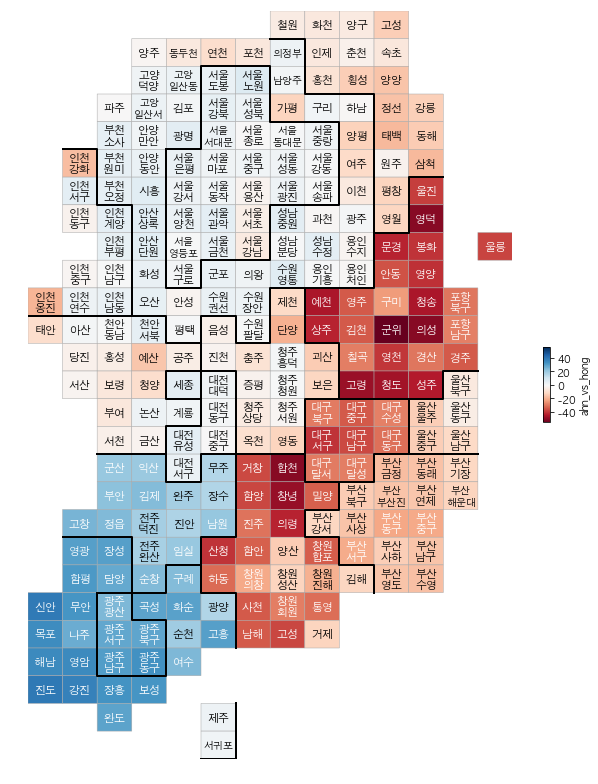

In [36]:
# drawKorea('ahn_vs_hong', final_elect_data, 'RdBu')

<hr>
<marquee><font size=3 color='brown'>The BigpyCraft find the information to design valuable society with Technology & Craft.</font></marquee>
<div align='right'><font size=2 color='gray'> &lt; The End &gt; </font></div>